# Training a statistical model to predict the snow covered area of the Alps

In [77]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

## Load MODIS snow cover fraction

In [101]:
f = 'AlpsScf01July'
# create date and scf arrays from Modis csv
dfscf = pd.read_csv('Modis/{}.csv'.format(f), index_col=0, decimal='.')
#dfscf = pd.read_csv('Modis/AlpsScf01July.csv', index_col=0)
doy = dfscf.index
dfdate = pd.DataFrame([pd.to_datetime(doy-1, unit='D', origin=str(y)) for y in dfscf.columns]).transpose()
dfdate.index = dfscf.index
dfdate.columns = dfscf.columns
dates = dfdate.transpose().stack(dropna=False)
scf = dfscf.transpose().stack(dropna=False)
# Make Y dataframe with SCF values to predict
Y = pd.concat([dates,scf], axis=1, keys=['dates','scf'])
Y.dropna(inplace=True)
# Use date at 6h as index to match Uerra convention
Y.index = [d.replace(hour=6)  for d in Y.dates] #.to_datetime64()
# this is the vector to predict
Y

,dates,scf
2000-11-01 06:00:00,2000-11-01,0.410
2000-11-02 06:00:00,2000-11-02,0.399
2000-11-03 06:00:00,2000-11-03,0.421
2000-11-04 06:00:00,2000-11-04,0.446
2000-11-05 06:00:00,2000-11-05,0.427
...,...,...
2022-03-11 06:00:00,2022-03-11,0.397
2022-03-12 06:00:00,2022-03-12,0.403
2022-03-13 06:00:00,2022-03-13,0.429
2022-03-14 06:00:00,2022-03-14,0.442


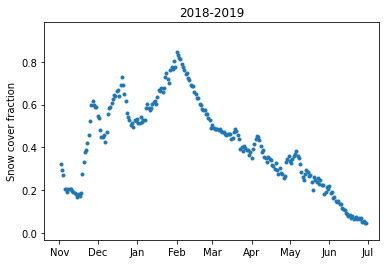

In [89]:
# plot water year 2018-2019
plt.plot(Y.dates,Y.scf, marker='.', ls='none')
plt.xlim([date(2018,10,20), date(2019,7,10)])
plt.title('2018-2019')
plt.ylabel('Snow cover fraction')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## Load UERRA snow depth

/Users/gascoins/Apps/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


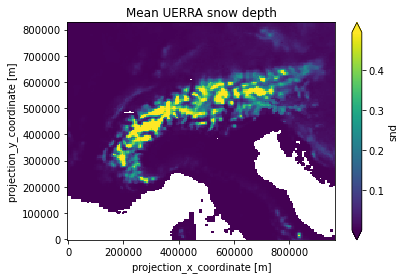

In [90]:
# Lazily load all HS netcdf 
ds = xr.open_mfdataset('snd_UERRA_MESCAN_SURFEX_1980_2014_alps/snd_UERRA_MESCAN_SURFEX_day_2*.nc')
# Map mean snow depth of the entire dataset
ds.snd.mean(dim='time').plot(robust=True)
plt.title('Mean UERRA snow depth');

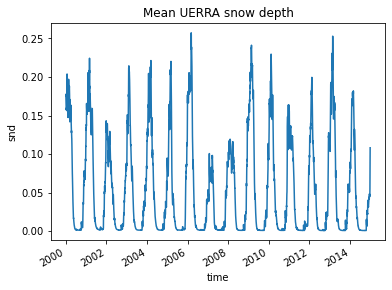

In [91]:
# plot mean snow depth
ds.snd.mean(dim=('x','y')).plot()
plt.title('Mean UERRA snow depth');

## Prepare training data and target values arrays

In [117]:
# create datesSel vector containing matching dates from both datasets
datesSel = list(set(Y.index.values).intersection(ds.time.values))
datesSel.sort()
# reduce UERRA dataset to these dates
dsSel = ds.sel(time=datesSel)
# Make X array with predictors
X = dsSel['snd'].values.reshape(len(datesSel),-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]
# This is the array of target values (snow cover fraction)
y = Y.loc[datesSel].scf
print('X dimensions:',X.shape)
print('y dimensions:',y.shape)


X dimensions: (3401, 21533)
y dimensions: (3401,)


## Train models

In [118]:
# function to test machine learning algorithms from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

def testMod(X,y,mod):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
    mod.fit(X_train,y_train)
    pred = mod.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    r2 = r2_score(y_test,pred)
    s = "R2={:.2f} RMSE={:.2f}".format(r2,rmse)
    plt.figure()
    plt.gca().set_aspect('equal')
    hb = plt.hexbin(y_test, pred, gridsize=20, cmap='cool', bins='log')
    cb = plt.colorbar(hb, label='log10(N)')
    _,top = plt.ylim()
    _,right = plt.xlim()
    m = max(top,right)
    plt.plot((0, m), (0, m), 'k-')
    plt.xlim(0,m)
    plt.ylim(0,m)
    plt.title(s)
    plt.xlabel('test')
    plt.ylabel('prediction');
    return mod

### Linear regression

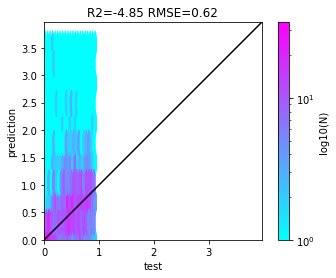

In [119]:
mod1 = testMod(X,y,LinearRegression())
# save model
with open('mod1{}.pickle'.format(f), 'wb') as handle:
    pickle.dump(mod1, handle)

### Gradient boost

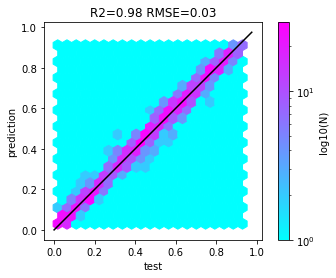

In [11]:
mod2 = testMod(X,y,GradientBoostingRegressor())
# save model
with open('mod2{}.pickle'.format(f), 'wb') as handle:
    pickle.dump(mod2, handle)

## Compare predicted and observed snow cover fractions

In [122]:
xmod1 = mod1.predict(X)
xmod2 = mod2.predict(X)

In [123]:
def plotModYear(year):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    fig.suptitle(('{}-{}'.format(year,year+1)))

    (ax1, ax2) = fig.subplots(ncols=2, sharex=True, sharey=True)

    ax1.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None', label='Observed from MODIS')
    ax1.plot(datesSel,xmod1, marker='.', linestyle = 'None', label='Predicted from UERRA')
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')

    ax2.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None')
    ax2.plot(datesSel,xmod2, marker='.', linestyle = 'None')
    ax2.set_xlabel('Time')

    ax1.set_title('Linear Regression')
    ax2.set_title('Gradient Boost')
    ax1.set_xlim([date(year,10,1), date(year+1,7,10)])
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1]);
        
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

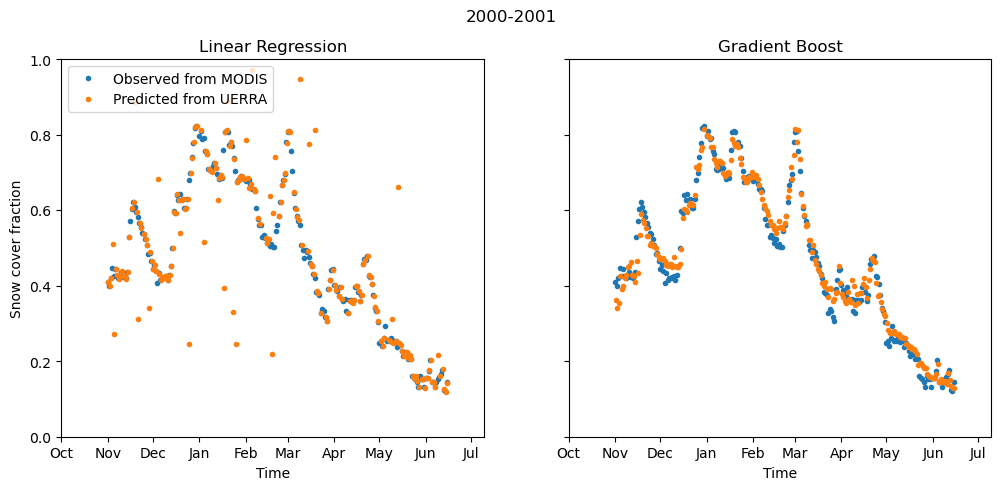

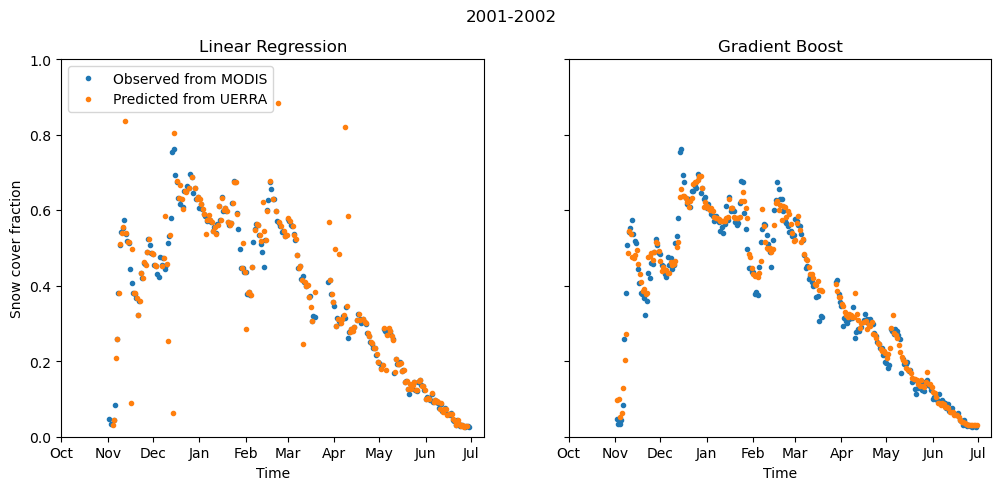

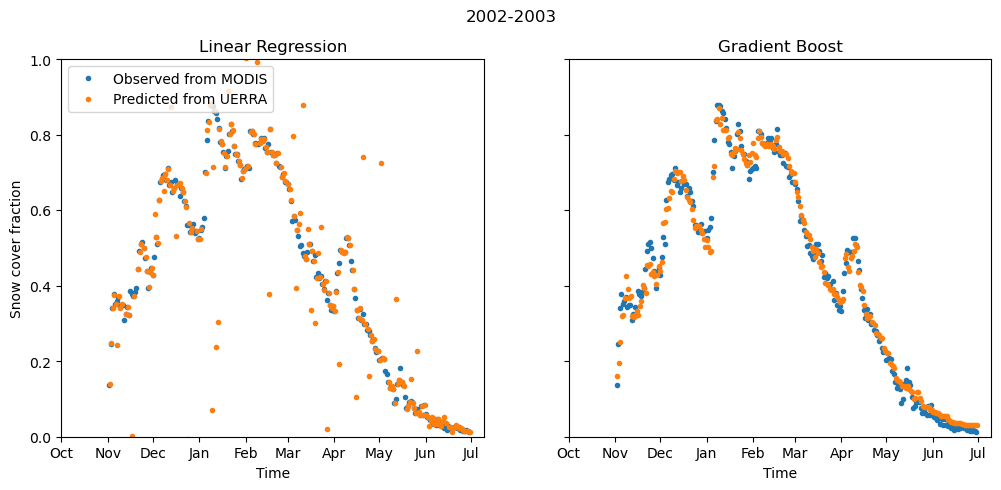

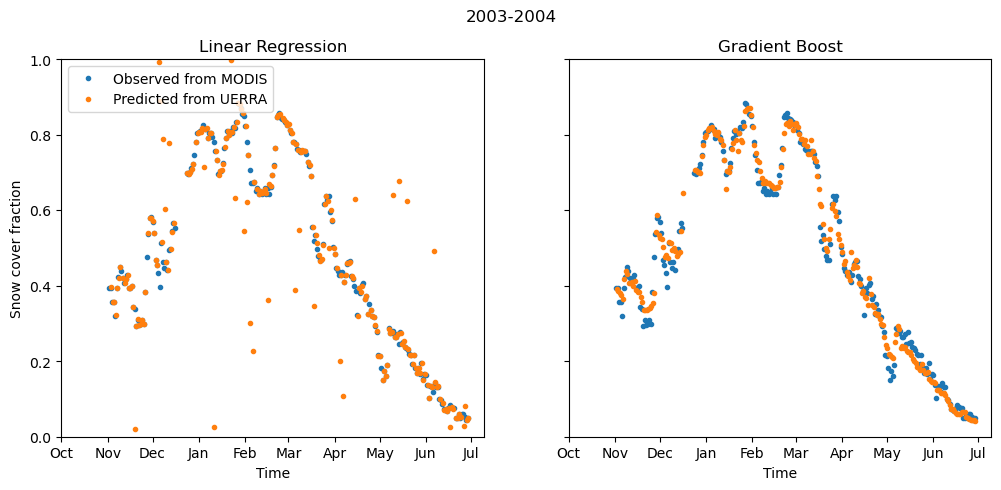

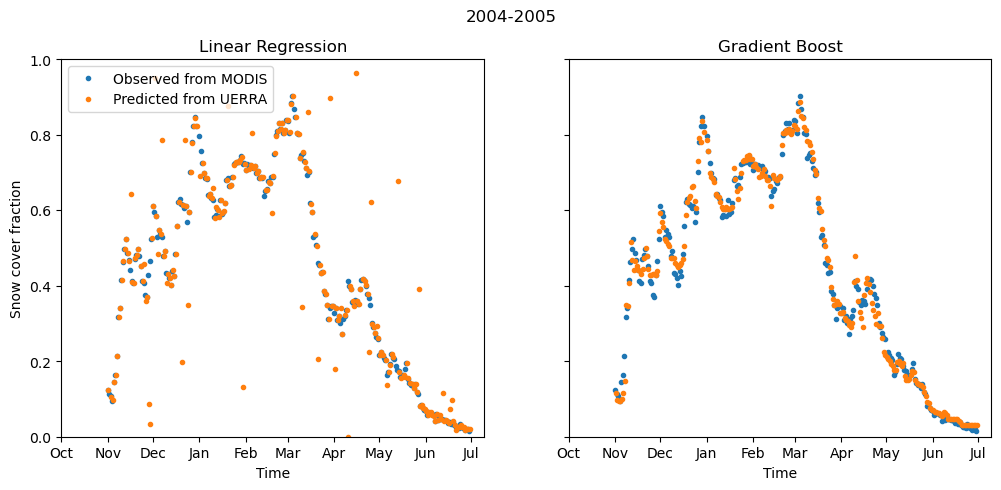

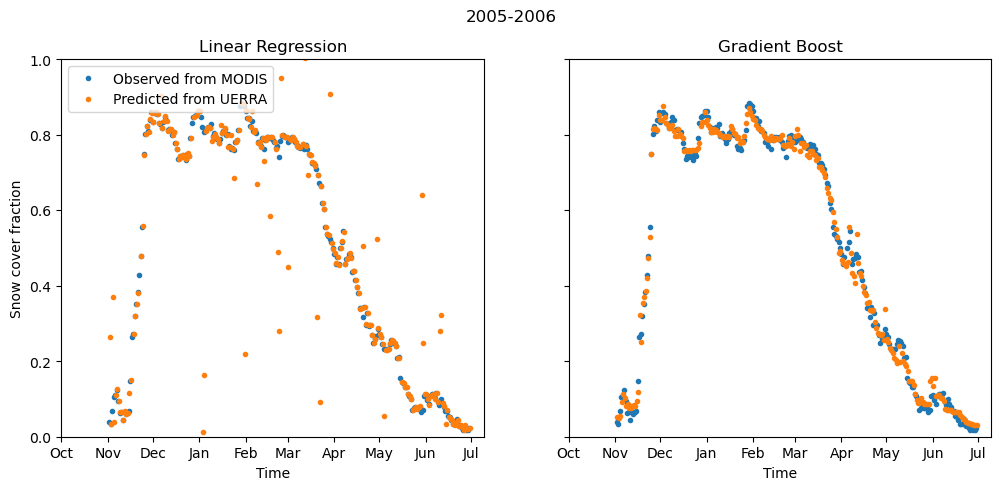

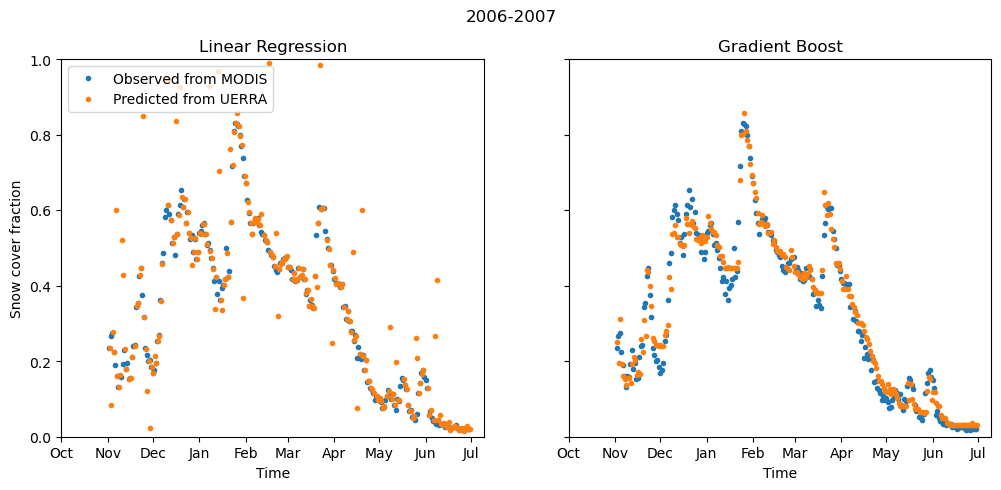

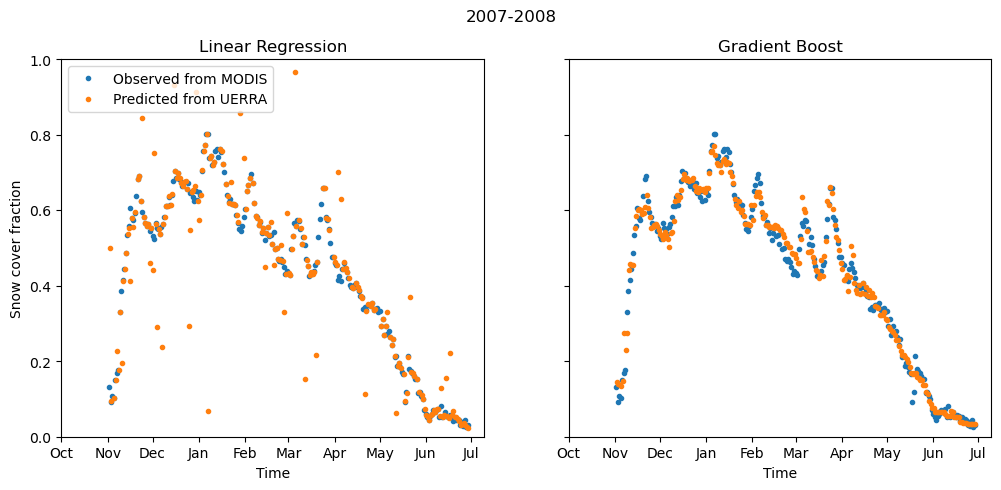

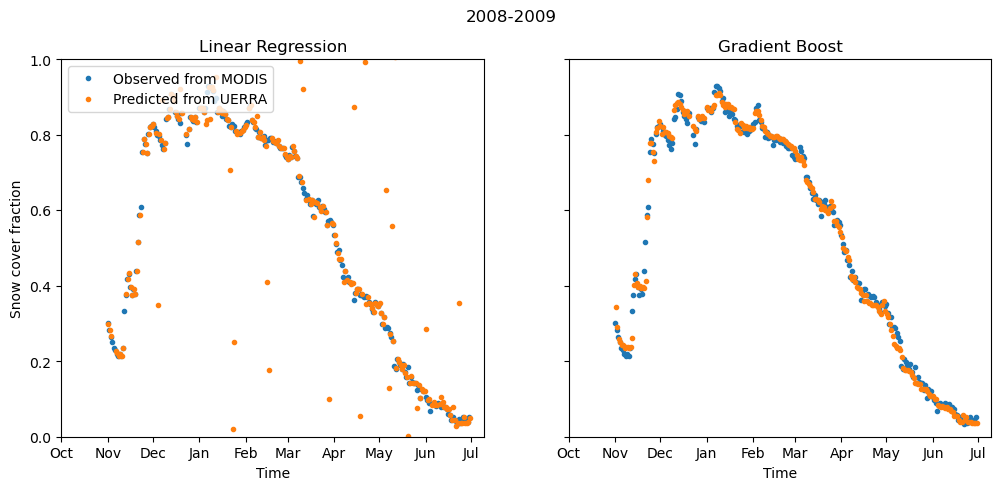

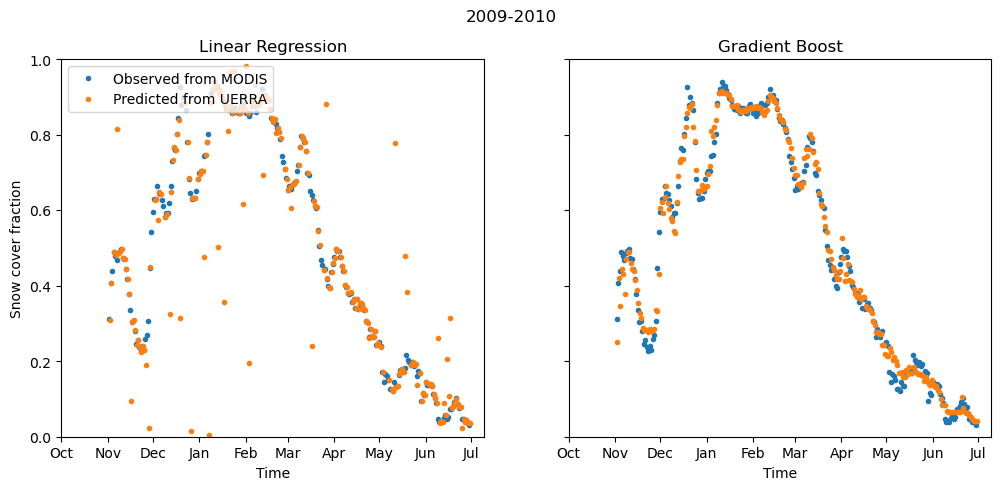

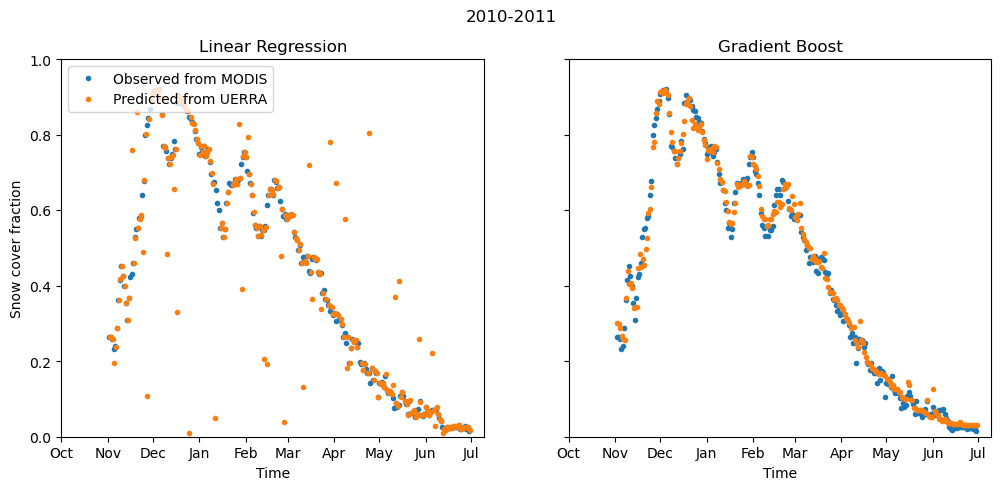

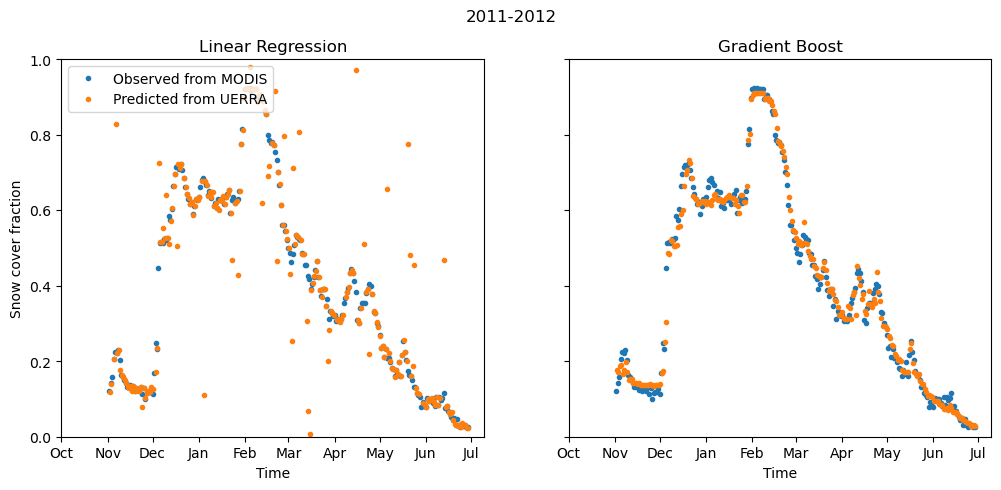

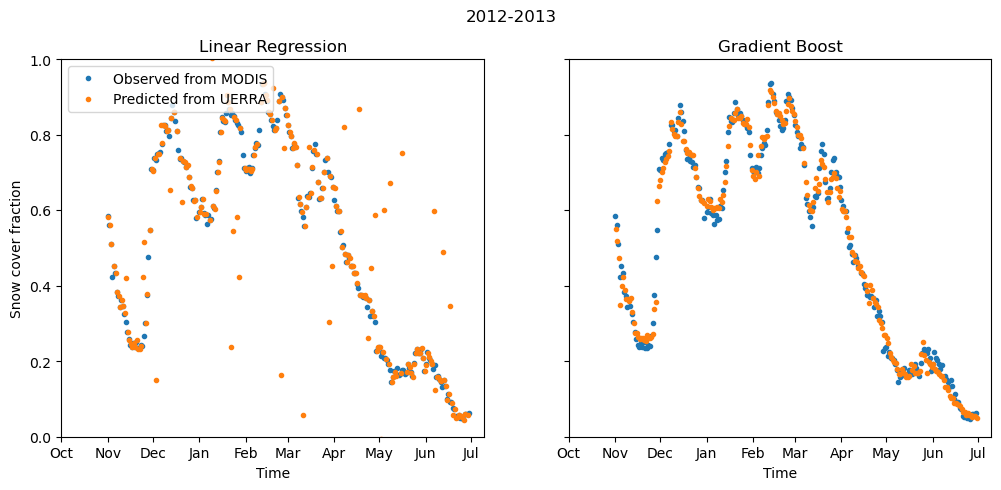

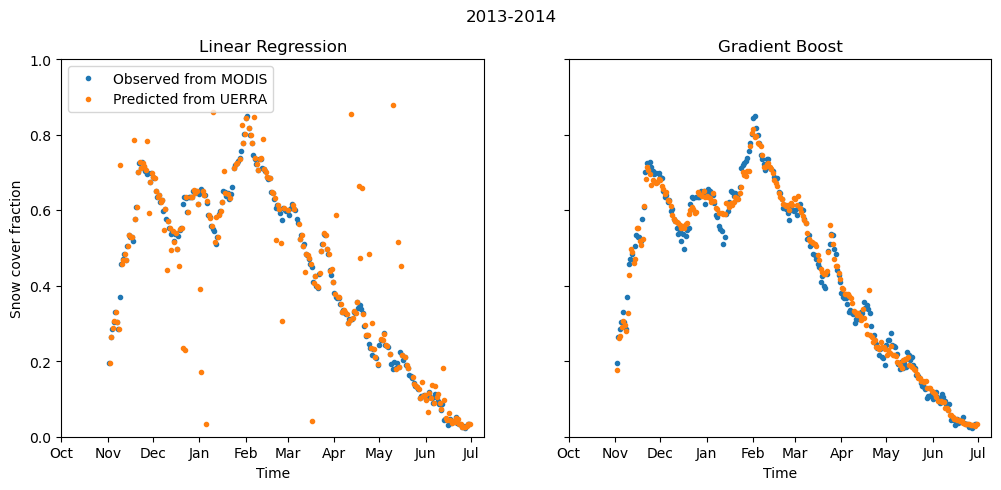

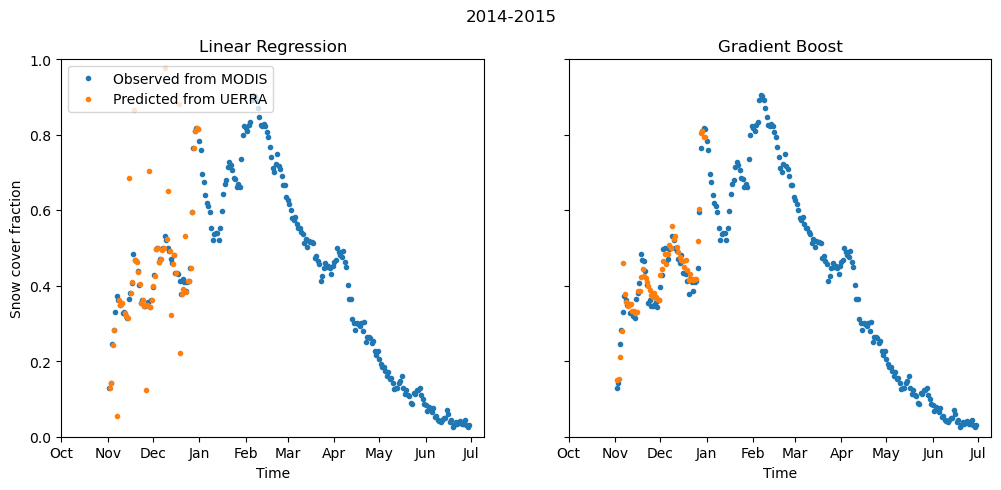

In [124]:
for year in range(2000,2015):
    plotModYear(year)


In [127]:
def plotYear(year,xmod):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    (ax1, ax2) = fig.subplots(ncols=2, sharey=True)

    ax1.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None', label='Observed from MODIS')
    ax1.plot(datesSel,xmod, marker='.', linestyle = 'None', label='Predicted from UERRA')
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')

    ax2.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None', label='Observed from MODIS')
    ax2.plot(datesSel,xmod, marker='.', linestyle = 'None', label='Predicted from UERRA')
    ax2.set_xlabel('Time')

    ax1.set_title('{}-{}'.format(year,year+1))
    ax2.set_title('{}-{}'.format(year+1,year+2))
    ax1.set_xlim([date(year,10,1), date(year+1,7,10)])
    ax2.set_xlim([date(year+1,10,1), date(year+2,7,10)])
    ax1.legend()
    ax2.legend()
    ax1.set_ylim([0,1])
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


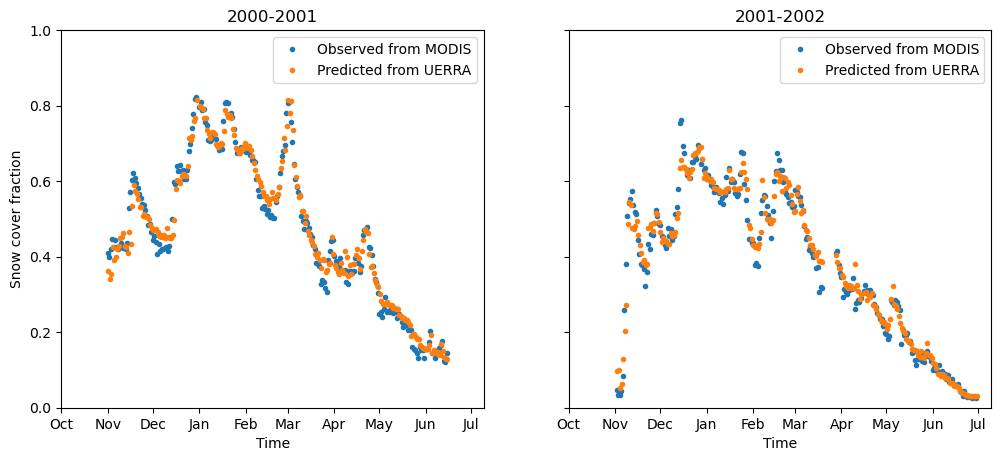

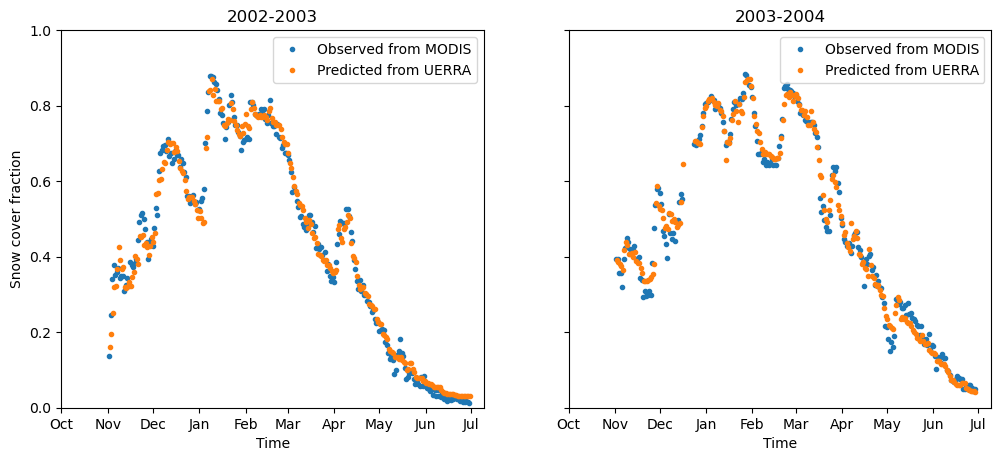

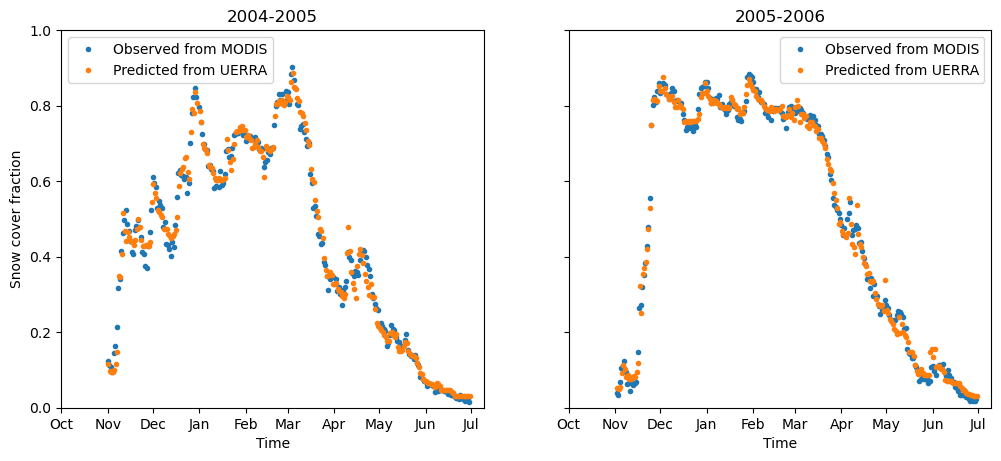

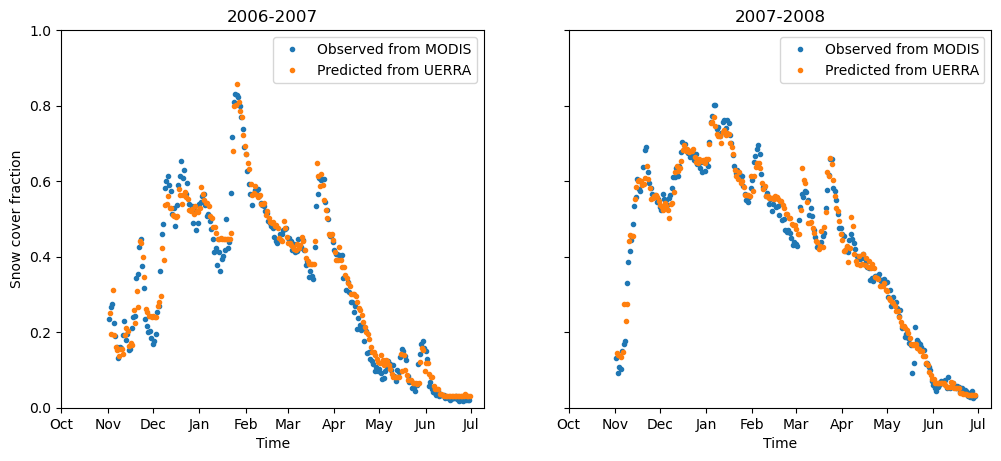

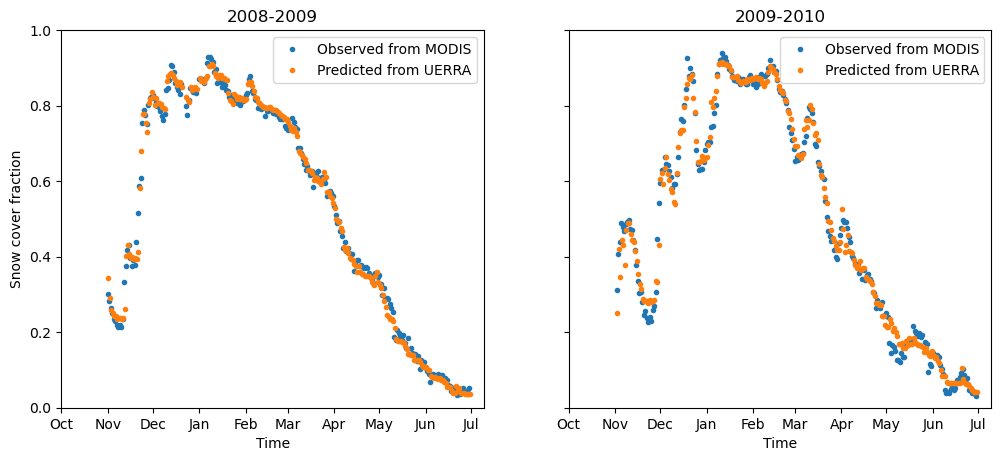

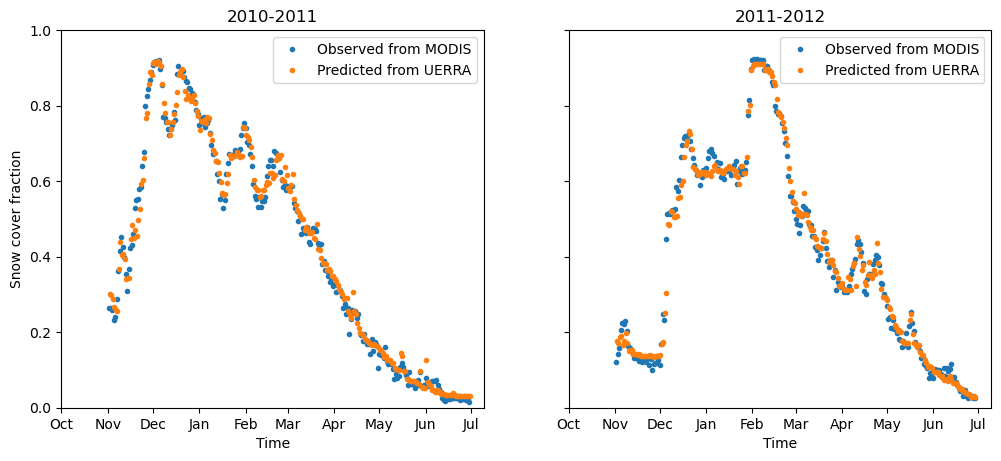

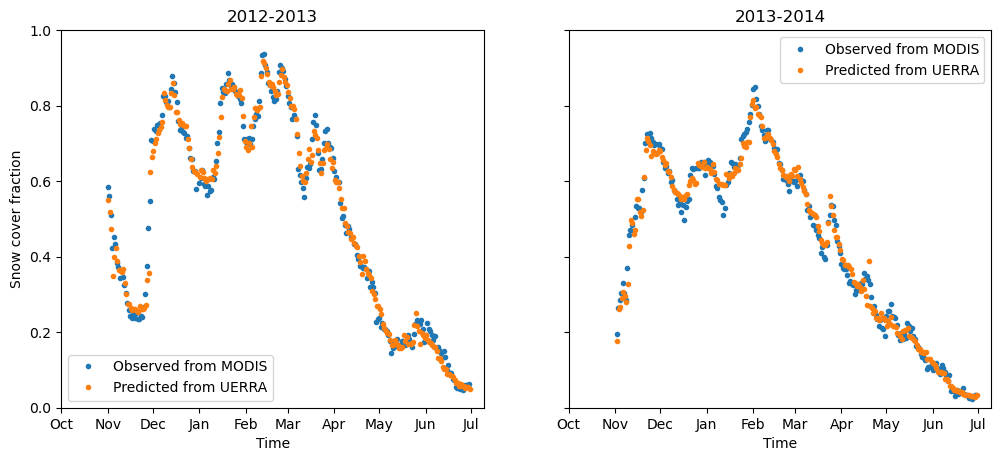

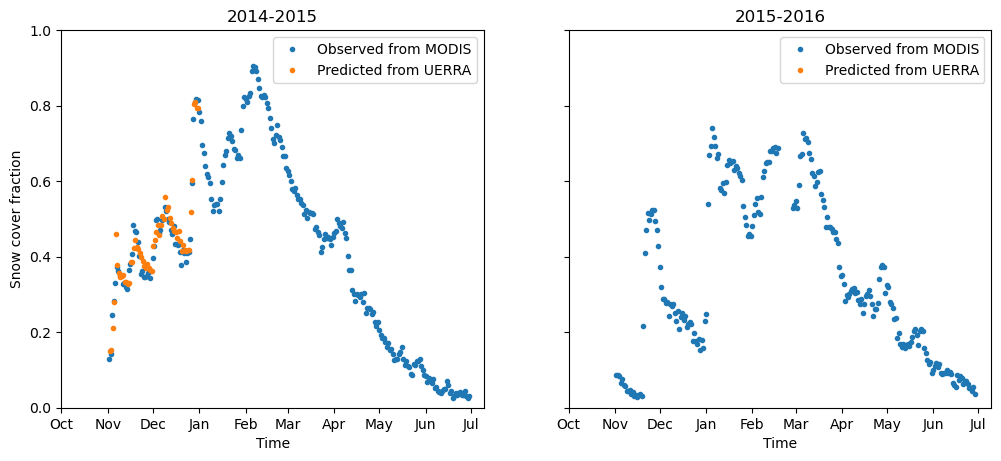

In [130]:
for year in range(2000,2015,2):
    plotYear(year,xmod2)